# Growing Neural Modules

## Import

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import mediapy
import optax
from cax.core.ca import CA, UnsupervisedCA
from cax.core.perceive.dwconv_perceive import DWConvPerceive
from cax.core.perceive.kernels import grad_kernel, identity_kernel
from cax.core.state import state_to_alive
from cax.core.update.nca_update import NCAUpdate
from cax.nn.pool import Pool
from cax.nn.vae import Encoder
from datasets import load_dataset
from flax import nnx
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [34]:
seed = 0
n_classes = 10
n_tasks = 2

# Encode task or input into intial seed
one_hot_seed_task = False
one_hot_seed_input = True
# Encode input into initial seed using encoder
encode_seed = False

seed_mode = np.argmax([one_hot_seed_task, one_hot_seed_input, encode_seed])

assert not all(
    [one_hot_seed_task, one_hot_seed_input, encode_seed]
), "Only one of the seed options should be True"

# Provide context to CA
one_hot_context_task = True
one_hot_context_input = False
# Encode context using encoder
encode_context = False

context_mode = np.argmax([one_hot_context_task, one_hot_context_input, encode_context])

assert not all(
    [one_hot_context_task, one_hot_context_input, encode_context]
), "Only one of the context options should be True"


# encoder takes 2 images as input
spatial_dims = (28, 28 * 2)
features = (1, 32, 32)
latent_size = 10

channel_size = 32
num_kernels = 3
hidden_size = 512
cell_dropout_rate = 0.5
context_size = max(latent_size, n_tasks, n_classes)

pool_size = 1_024
batch_size = 8
num_steps = 64
learning_rate = 1e-3

key = jax.random.PRNGKey(seed)
rngs = nnx.Rngs(seed)

tasks = {0: "id_0", 1: "id_1", 2: "add", 3: "mul", 4: "sub", 5: "xor"}

In [35]:
def id_0(x, y):
    return x


def id_1(x, y):
    return y


def add(x, y):
    return (x + y) % n_classes


def mul(x, y):
    return (x * y) % n_classes


def sub(x, y):
    return (x - y) % n_classes


def xor(x, y):
    return (x != y) % n_classes


def get_task_switch(task, *operands):
    return jax.lax.switch(task, [id_0, id_1, add, mul, sub, xor], *operands)

## Dataset

In [36]:
ds = load_dataset("ylecun/mnist")

image_train = jnp.expand_dims(
    jnp.array(ds["train"]["image"], dtype=jnp.float32) / 255, axis=-1
)
image_test = jnp.expand_dims(
    jnp.array(ds["test"]["image"], dtype=jnp.float32) / 255, axis=-1
)

label_train = jnp.array(ds["train"]["label"])
label_test = jnp.array(ds["test"]["label"])

state_shape = image_train.shape[1:3] + (channel_size,)
mid = (size // 2 for size in state_shape[:-1])

mediapy.show_images(image_train[:8], width=64, height=64)

,,,,,,,


In [37]:
image_train.shape

(60000, 28, 28, 1)

In [38]:
mediapy.write_image("image.png", jnp.squeeze(image_train[0]))

## Init state

In [39]:
def get_problem(key, target_1, target_2, task):
    key, subkey = jax.random.split(key)
    # print(target_1, target_2)
    target = get_task_switch(task, target_1, target_2)
    # print(target)
    # target_indexes = jnp.where(label_train == target)[0]
    target_matches = jnp.where(label_train == target, size=len(label_train))[0]

    # Use dynamic_slice to get a single random index
    random_index = jax.random.randint(subkey, (), 0, jnp.sum(label_train == target))
    target_index = jax.lax.dynamic_slice(target_matches, (random_index,), (1,))[0]

    # print(target_index)
    return target_index, target

In [40]:
def init_state(key, ca=None):

    key, input_key, task_key, problem_key, encode_key = jax.random.split(key, 5)

    state_shape = image_train.shape[1:3] + (channel_size,)
    state = jnp.zeros(state_shape)
    mid = tuple(size // 2 for size in state_shape[:-1])

    input_index = jax.random.choice(
        input_key, image_train.shape[0], shape=(2,), replace=False
    )
    task = jax.random.choice(task_key, n_tasks)

    labels = label_train[input_index]
    target_index, task_label = get_problem(problem_key, *labels, task)

    # Set the "alive" cell
    state = state.at[mid + (channel_size - 1,)].set(1.0)

    def one_hot_seed_input(state):
        # print("One hot seed input")
        # encode targets into state
        one_hot_1 = jax.nn.one_hot(labels[0], num_classes=n_classes)
        one_hot_2 = jax.nn.one_hot(labels[1], num_classes=n_classes)
        # Set the one-hot encoded labels
        state = state.at[
            mid + (slice(channel_size - n_classes - 1, channel_size - 1),)
        ].set(one_hot_1)

        # If you want to set the second label as well, uncomment and adjust the following line:
        state = state.at[
            mid
            + (slice(channel_size - 2 * n_classes - 1, channel_size - n_classes - 1),)
        ].set(one_hot_2)

    def one_hot_seed_task(state):
        # print("One hot seed task")
        # encode task into state
        one_hot_task = jax.nn.one_hot(task, num_classes=n_tasks)
        state = state.at[
            mid + (slice(channel_size - n_tasks - 1, channel_size - 1),)
        ].set(one_hot_task)

    def encode_seed(state):
        # print("Encode seed")
        if ca is not None:
            # encode input into state
            inputs = image_train[input_index]
            print(inputs.shape)
            input = jnp.concatenate([inputs[0], inputs[1]], axis=-2)
            target_enc = ca.encode(input, encode_key)
            try:
                state = state.at[
                    mid + (slice(channel_size - n_classes - 1, channel_size - 1),)
                ].set(target_enc)
            except:
                pass

    jax.lax.switch(
        seed_mode, [one_hot_seed_task, one_hot_seed_input, encode_seed], state
    )

    return {
        "state": state,
        "target_index": target_index,
        "task": task,
        "task_label": task_label,
        "input_index": input_index,
        "input_labels": labels,
    }

In [41]:
seed_mode

np.int64(1)

## Model

In [42]:
def get_model():
    encoder = Encoder(spatial_dims, features, latent_size, rngs)
    perceive = DWConvPerceive(channel_size, rngs)
    update = NCAUpdate(
        channel_size,
        context_size + num_kernels * channel_size,
        (hidden_size,),
        rngs,
        cell_dropout_rate=cell_dropout_rate,
    )
    kernel = jnp.concatenate([identity_kernel(ndim=2), grad_kernel(ndim=2)], axis=-1)
    kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
    perceive.dwconv.kernel = nnx.Param(kernel)
    ca = UnsupervisedCA(perceive, update, encoder)
    params = nnx.state(ca, nnx.Param)
    print(
        "Number of params:",
        jax.tree_util.tree_reduce(lambda x, y: x + y.size, params, 0),
    )
    return ca

### Pool

In [43]:
def get_pool(key, ca=None):

    key, subkey = jax.random.split(key)

    keys = jax.random.split(subkey, pool_size)
    new_data = jax.vmap(
        lambda key: init_state(
            key,
            ca,
        )
    )(keys)

    pool = Pool.create(**new_data)
    return pool

### Optimizer

In [44]:
def get_optimizer(ca):
    lr_sched = optax.linear_schedule(
        init_value=learning_rate,
        end_value=0.1 * learning_rate,
        transition_steps=50_000,
    )
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=lr_sched),
    )
    grad_params = nnx.All(
        nnx.Param, nnx.Any(nnx.PathContains("update"), nnx.PathContains("encoder"))
    )
    optimizer = nnx.Optimizer(ca, optimizer, wrt=grad_params)
    return optimizer, grad_params

## Train

### Loss

In [45]:
def mse(state, target):
    return jnp.mean(jnp.square(state_to_alive(state) - target))


@nnx.jit
def loss_fn(ca, state, target, context, key):

    key, randint_key = jax.random.split(key)

    state = nnx.vmap(
        lambda state, input: ca(state, input, num_steps=num_steps, all_steps=True)
    )(state, context)

    index = jax.random.randint(
        randint_key, (state.shape[0],), num_steps // 2, num_steps
    )
    state = state[jnp.arange(state.shape[0]), index]

    loss = mse(state, target)
    # Add regularization loss to avoid null outputs

    regularization_loss = jnp.mean(jnp.square(state_to_alive(state)))
    loss += 1e-2 * regularization_loss

    return loss, state

### Train Step

In [46]:
@nnx.jit
def train_step(ca, optimizer, pool, key, batch_size=batch_size):
    sample_key, init_state_key, loss_key, encode_key = jax.random.split(key, 4)

    # Sample from pool
    pool_index, sample = pool.sample(sample_key, sample_size=batch_size)

    current_data = {k: sample[k] for k in sample.keys()}
    current_target = image_train[current_data["target_index"]]

    # Sort by descending loss
    sort_index = jnp.argsort(
        jax.vmap(mse)(current_data["state"], current_target), descending=True
    )
    pool_index = pool_index[sort_index]
    current_data = {k: current_data[k][sort_index] for k in current_data.keys()}

    # Sample a new target to replace the worst
    new_data = init_state(init_state_key, ca)

    for k in current_data.keys():
        current_data[k] = current_data[k].at[0].set(new_data[k])

    current_target = image_train[current_data["target_index"]]
    current_label = label_train[current_data["input_index"]]
    current_task = current_data["task"]

    current_inputs = image_train[current_data["input_index"]]
    current_input = jnp.concatenate(
        [current_inputs[:, 0], current_inputs[:, 1]], axis=-2
    )
    # current_input = image_train[current_data["input_index"]][:, 0]
    print(current_input.shape)

    def encode_context():
        if ca is not None:
            context = ca.encode(current_input, encode_key)
            context = jnp.concatenate(
                [context, jnp.zeros((batch_size, context_size - latent_size))], axis=-1
            )
        else:
            context = jnp.zeros((batch_size, context_size))

        return context

    def one_hot_label():
        context = jax.nn.one_hot(
            current_label[:, 0], num_classes=n_classes
        ) + jax.nn.one_hot(current_label[:, 1], num_classes=n_classes)
        
        context = jnp.concatenate(
            [context, jnp.zeros((batch_size, context_size - n_classes))], axis=-1
        )
        return context

    def one_hot_task():
        context = jax.nn.one_hot(current_task, num_classes=n_tasks)
        context = jnp.concatenate(
            [context, jnp.zeros((batch_size, context_size - n_tasks))], axis=-1
        )
        return context

    context = jax.lax.switch(
        context_mode,
        [one_hot_task, one_hot_label, encode_context],
    )

    (loss, current_state), grad = nnx.value_and_grad(
        loss_fn, has_aux=True, argnums=nnx.DiffState(0, grad_params)
    )(ca, current_data["state"], current_target, context, loss_key)

    current_data["state"] = current_state

    optimizer.update(grad)

    pool = pool.add(pool_index, **current_data)

    return loss, pool

In [47]:
context_mode

np.int64(0)

## Visualize targets

In [48]:
key, subkey = jax.random.split(key)

keys = jax.random.split(subkey, 8)
new_data = jax.vmap(lambda key: init_state(key))(keys)

key, subkey = jax.random.split(key)
target = image_train[new_data["target_index"]]
task = new_data["task"]
input_labels = new_data["input_labels"]

titles = [
    f"{tasks[t.item()]} {t1.item()} {t2.item()}"
    for t, t1, t2 in zip(task, input_labels[:, 0], input_labels[:, 1])
]

mediapy.show_images(target, width=128, height=128, titles=titles)

id_0 3 6,id_1 8 8,id_0 3 4,id_0 3 5,id_1 2 4,id_0 5 0,id_1 8 9,id_0 9 5


### Main Loop

In [49]:
class Trainer:
    def __init__(self, key, pool, ca, optimizer):
        self.key = key
        self.pool = pool
        self.ca = ca
        self.optimizer = optimizer

    def train(self, n_steps):
        pbar = tqdm(range(n_steps))
        self.losses = [] if not hasattr(self, "losses") else self.losses

        for i in pbar:
            self.key, subkey = jax.random.split(self.key)
            loss, pool = train_step(self.ca, self.optimizer, self.pool, subkey)
            # pbar.set_postfix(loss=loss)
            # Calculate smooth slope of the loss to gauge variations
            window_size = n_steps // 100
            self.losses.append(loss.mean())

            if i >= window_size:
                # Calculate moving average
                window = jnp.array(self.losses[-window_size:])
                moving_avg = jnp.mean(window)

                # Calculate slope using first and last values in the window
                slope = (window[-1] - window[0]) / (window_size - 1)

                pbar.set_postfix(
                    avg_loss=np.format_float_scientific(moving_avg, 3),
                    slope=np.format_float_scientific(slope, 3),
                )
            else:
                pbar.set_postfix(loss=np.format_float_scientific(loss.mean(), 3))

            self.losses.append(loss.mean())
        return self.losses, pool

    def plot_loss(self):
        v = len(self.losses) // 10
        plt.plot(jnp.convolve(jnp.array(self.losses), jnp.ones(v) / v, mode="valid"))

        plt.show()

In [50]:
ca = get_model()
optimizer, grad_params = get_optimizer(ca)
pool = get_pool(key)

trainer = Trainer(key, pool, ca, optimizer)

Number of params: 9982004


In [51]:
pool_index, sample = pool.sample(key, sample_size=1)

In [52]:
losses, pool = trainer.train(2**12)

  0%|          | 0/4096 [00:00<?, ?it/s]

(2, 28, 28, 1)
(8, 28, 56, 1)


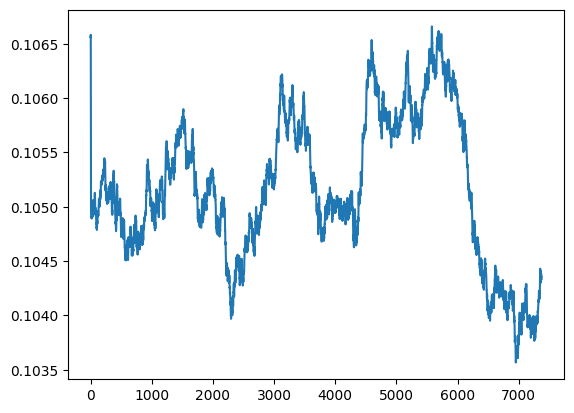

In [32]:
trainer.plot_loss()

## Visualize

In [33]:
key, subkey = jax.random.split(key)

keys = jax.random.split(subkey, 8)
new_data = jax.vmap(init_state)(keys)

key, subkey = jax.random.split(key)
target = image_train[new_data["target_index"]]
task = new_data["task"]
input_labels = new_data["input_labels"]

input = jnp.concatenate(
    [
        image_train[new_data["input_index"][:, 0]],
        image_train[new_data["input_index"][:, 1]],
    ],
    axis=-2,
)

if one_hot_context_task:
    context = jax.nn.one_hot(task, num_classes=n_tasks)
elif one_hot_context_input:
    context = jax.nn.one_hot(
        input_labels[:, 0], num_classes=n_classes
    ) + jax.nn.one_hot(input_labels[:, 1], num_classes=n_classes)
elif encode_context:
    context = ca.encode(input, subkey)
else:
    context = jnp.zeros((batch_size, context_size))

titles = [
    f"{tasks[t.item()]} {t1.item()} {t2.item()}"
    for t, t1, t2 in zip(task, input_labels[:, 0], input_labels[:, 1])
]

state = nnx.vmap(
    lambda state, input: ca(state, input, num_steps=2 * num_steps, all_steps=True)
)(new_data["state"], context)

mediapy.show_images(target, width=128, height=128, titles=titles)
mediapy.show_videos(
    jnp.squeeze(state_to_alive(state)), width=128, height=128, codec="gif"
)

id_1 2 7,id_0 2 1,id_0 5 2,id_0 2 7,id_1 2 5,id_1 2 1,id_0 1 7,id_1 1 1


,,,,,,,
